## Interface with `py_sc_fermi`

To extend the analysis available in doped, we include and optional interface with the [`py_sc_fermi`]() code for analysis of self-consistent Fermi energies and defect concentrations. We'll go through how to use the interface to study defect concentrations in a couple of example systems.

### Cu<sub>2</sub>SiSe<sub>3</sub>

The first step is simply to load in a `FermiSolver` object, this is a wrapper for a `py-sc-fermi` `DefectSystem` object and is designed so that you can generate these from your doped `DefectPhaseDiagram` objects.

In [1]:
from doped.interface.py_sc_fermi import FermiSolver
from monty.serialization import loadfn
import matplotlib.pyplot as plt

style_file = "../doped/utils/doped.mplstyle"
plt.style.use(style_file)

# we need to specify the path to the vasprun.xml file
# that was used for the DOS calculation. This is because
# we need to accurately account for the electronic carrier concentrations
# as well as the ionic defect concentrations
vasprun_path = "Cu2SiSe3/vasprun.xml"

# the defect phase diagram contains all the information about the
# defect formation energies and transition levels
pd = loadfn("Cu2SiSe3/cu2sise3_dpd.json")

# and the chemical potentials can then be used to specify the
# defect formation energies under different conditions
chemical_potentials = loadfn("Cu2SiSe3/cu2sise3_chempots.json")

# initialize the FermiSolver object
fs = FermiSolver(pd, vasprun_path)

# we can then pick a chemical potential to use as a reference
mu = chemical_potentials["facets"]["Cu2SiSe3-Cu15Si4-SiSe2"]

# "report" then prints out the defect lots of information about the defect system
# including the defect concentrations, the Fermi level, and the carrier concentrations
defect_system = fs.defect_system_from_chemical_potentials(mu, temperature=600)
defect_system.report()

Temperature :      600  (K)
SC Fermi level :      0.2855952948036835  (eV)
Concentrations:
n (electrons)  : 6306416.559151996 cm^-3
p (holes)      : 4.554002290917213e+16 cm^-3
as_5_Si_on_Se      : 192024583.96467796 cm^-3, (percentage of defective sites: 3.87e-11 %)
as_2_Si_on_Cu      : 9030.318415998654 cm^-3, (percentage of defective sites: 1.82e-15 %)
vac_3_Si       : 0.016618106477737597 cm^-3, (percentage of defective sites: 3.35e-21 %)
Int_Cu_4       : 234925426226206.66 cm^-3, (percentage of defective sites: 4.74e-05 %)
vac_1_Cu       : 4.577494832734216e+16 cm^-3, (percentage of defective sites: 0.00923 %)
as_2_Se_on_Cu      : 0.002569043538605689 cm^-3, (percentage of defective sites: 5.18e-22 %)
as_3_Se_on_Si      : 6.754651691590303e-07 cm^-3, (percentage of defective sites: 1.36e-25 %)
vac_4_Se       : 161448420266.32535 cm^-3, (percentage of defective sites: 3.25e-08 %)
Int_Si_12      : 0.004176008880258898 cm^-3, (percentage of defective sites: 8.42e-22 %)
Int_Se_7      

Once we have the base defect system inititalised, we can scan over a range of temperatures to get defect concentrations.

In [2]:
# define a range of temperatures to scan over
import numpy as np
temp_range = np.arange(300, 1000, 20)

# scan over the temperature range and save the results to a pandas dataframe
temperature_df = fs.scan_temperature_and_save(mu, temp_range)

# print the generated dataframe
print(temperature_df)


                        defect concentrations. This is likely a natural result of the use of
                        a numerical solver for the Fermi energy search. This can likely be ignored
                        though you should always check the final results are reasonable.
                        electron and hole concentrations. This is likely a natural result of the use of
                        a numerical solver for the Fermi energy search. This can likely be ignored
                        though you should always check the final results are reasonable.
            Defect  Concentration  Temperature  Fermi Level
0               p0   2.520652e+12          300     0.343928
1               n0   3.277440e-04          300     0.343928
2    as_5_Si_on_Se   4.205987e-06          300     0.343928
3    as_2_Si_on_Cu   1.075188e-15          300     0.343928
4         vac_3_Si   2.883761e-25          300     0.343928
..             ...            ...          ...          ...
450  as

Then with this information, we can plot the concentrations of different defects as a function of 
temperature. 

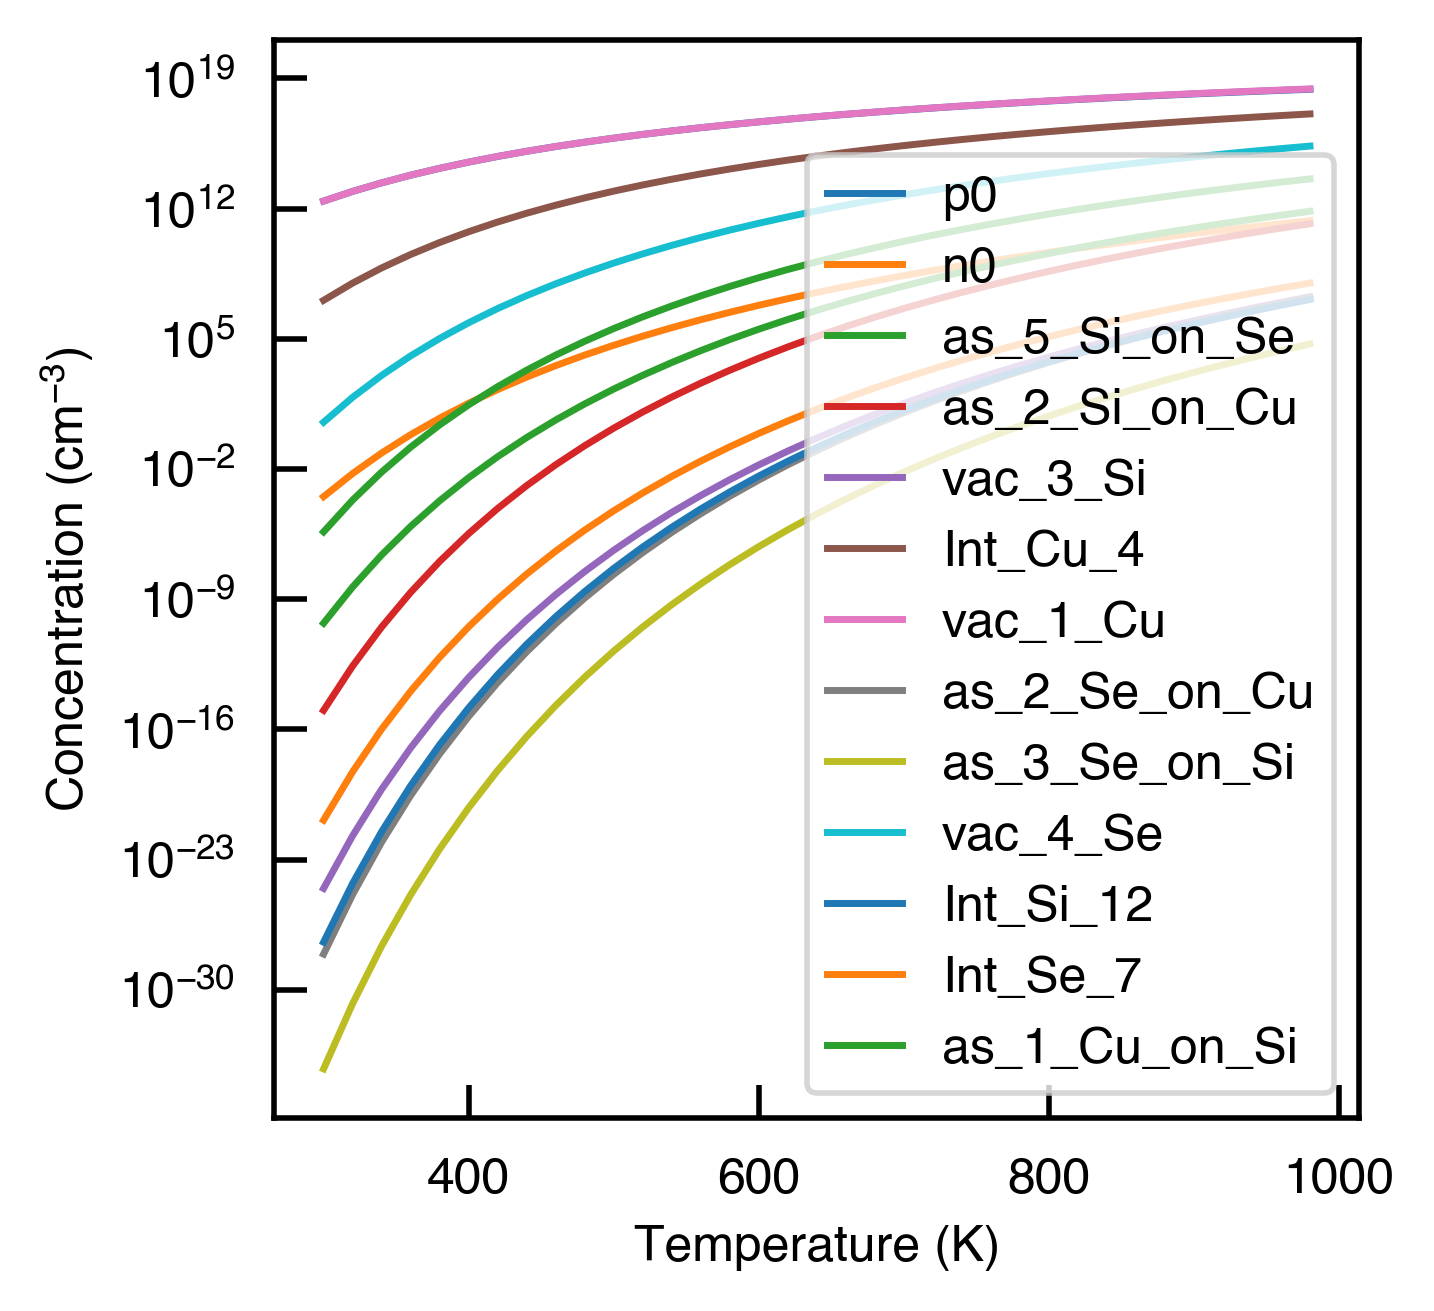

In [3]:
import matplotlib.pyplot as plt

# Create a unique list of defects
unique_defects = temperature_df['Defect'].unique()

# Loop through each unique defect to plot it
for defect in unique_defects:
    subset = temperature_df[temperature_df['Defect'] == defect]
    plt.plot(subset['Temperature'], subset['Concentration'], label=defect)

# Use a log scale on the y-axis due to the wide range of concentrations
plt.yscale('log')

# Add labels and title
plt.xlabel('Temperature (K)')
plt.ylabel(r'Concentration (cm$^{-3}$)')

# Add a legend to distinguish each defect type
plt.legend()

# Show the plot
plt.show()

Great! But the plot is a bit messy. We can of course refine it however we want via matplotlib to get something a bit more readable. Maybe just highlighting a few of the most important defects.

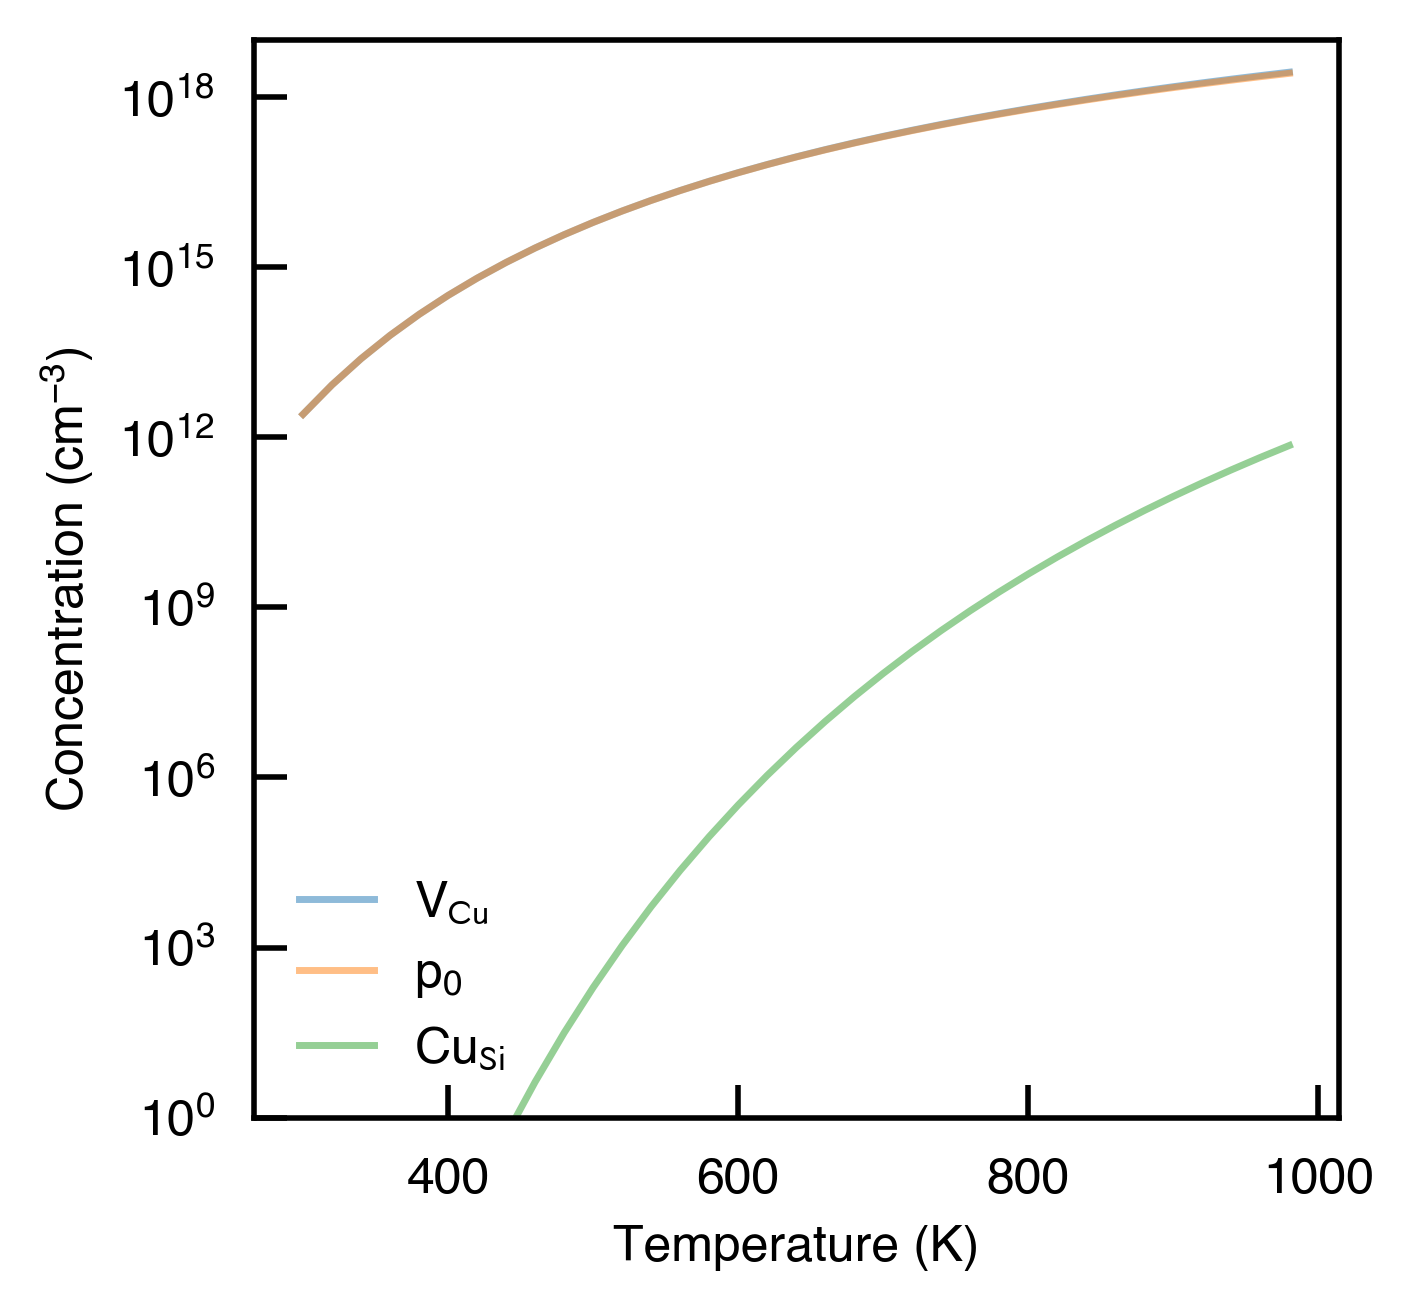

In [4]:
# Create a unique list of defects
defects_of_interest = ["vac_1_Cu", "p0", "as_1_Cu_on_Si"]

# Loop through each unique defect to plot it
for defect in defects_of_interest:
    subset = temperature_df[temperature_df['Defect'] == defect]

    # Add a label for each defect
    if defect == "p0":
        label = "$p_0$"
    elif defect == "as_1_Cu_on_Si":
        label = "Cu$_\mathrm{{{Si}}}$"
    elif defect == "vac_1_Cu":
        label = "$V_\mathrm{{{Cu}}}$"
    
    plt.plot(subset['Temperature'], subset['Concentration'], alpha= 0.5, label=label)

# Use a log scale on the y-axis due to the wide range of concentrations
plt.yscale('log')

# Add labels and title
plt.xlabel('Temperature (K)')
plt.ylabel(r'Concentration (cm$^{-3}$)')
plt.ylim(1, 1e19)

# Add a legend to distinguish each defect type
plt.legend(frameon=False)

# Show the plot
plt.show()

One thing we might be interested in is estimating the effect of annealing on carrier concentrations. We can also simulate different annealing effects by, for example, fixing the concentration of defects at high temperature and then recalculating the electron and hole concentrations at lower values.

In [5]:
# define a range of temperatures to scan over
import numpy as np
temp_range = np.arange(300, 1000, 20)

# scan over the temperature range and save the results to a pandas dataframe
anneal_temperature_df = fs.scan_temperature_and_save(mu, temp_range, anneal_temperature=1000, level = "DefectSpecies")

print(anneal_temperature_df)

            Defect  Concentration  Temperature  Fermi Level
0               p0   2.934500e+18          300    -0.022682
1               n0   2.273831e-10          300    -0.022682
2    as_5_Si_on_Se   5.767903e+13          300    -0.022682
3    as_2_Si_on_Cu   2.553173e+11          300    -0.022682
4         vac_3_Si   3.517379e+07          300    -0.022682
..             ...            ...          ...          ...
450  as_3_Se_on_Si   1.170461e+05          980     0.223623
451       vac_4_Se   3.076450e+15          980     0.223623
452      Int_Si_12   2.544809e+07          980     0.223623
453       Int_Se_7   1.779309e+08          980     0.223623
454  as_1_Cu_on_Si   1.132234e+12          980     0.223623

[455 rows x 4 columns]


We can then plot this data to show how the electron concentration changes as a function of temperature when the defect species have fixed concentrations vs when they are free to reequilibrate at every temperature.

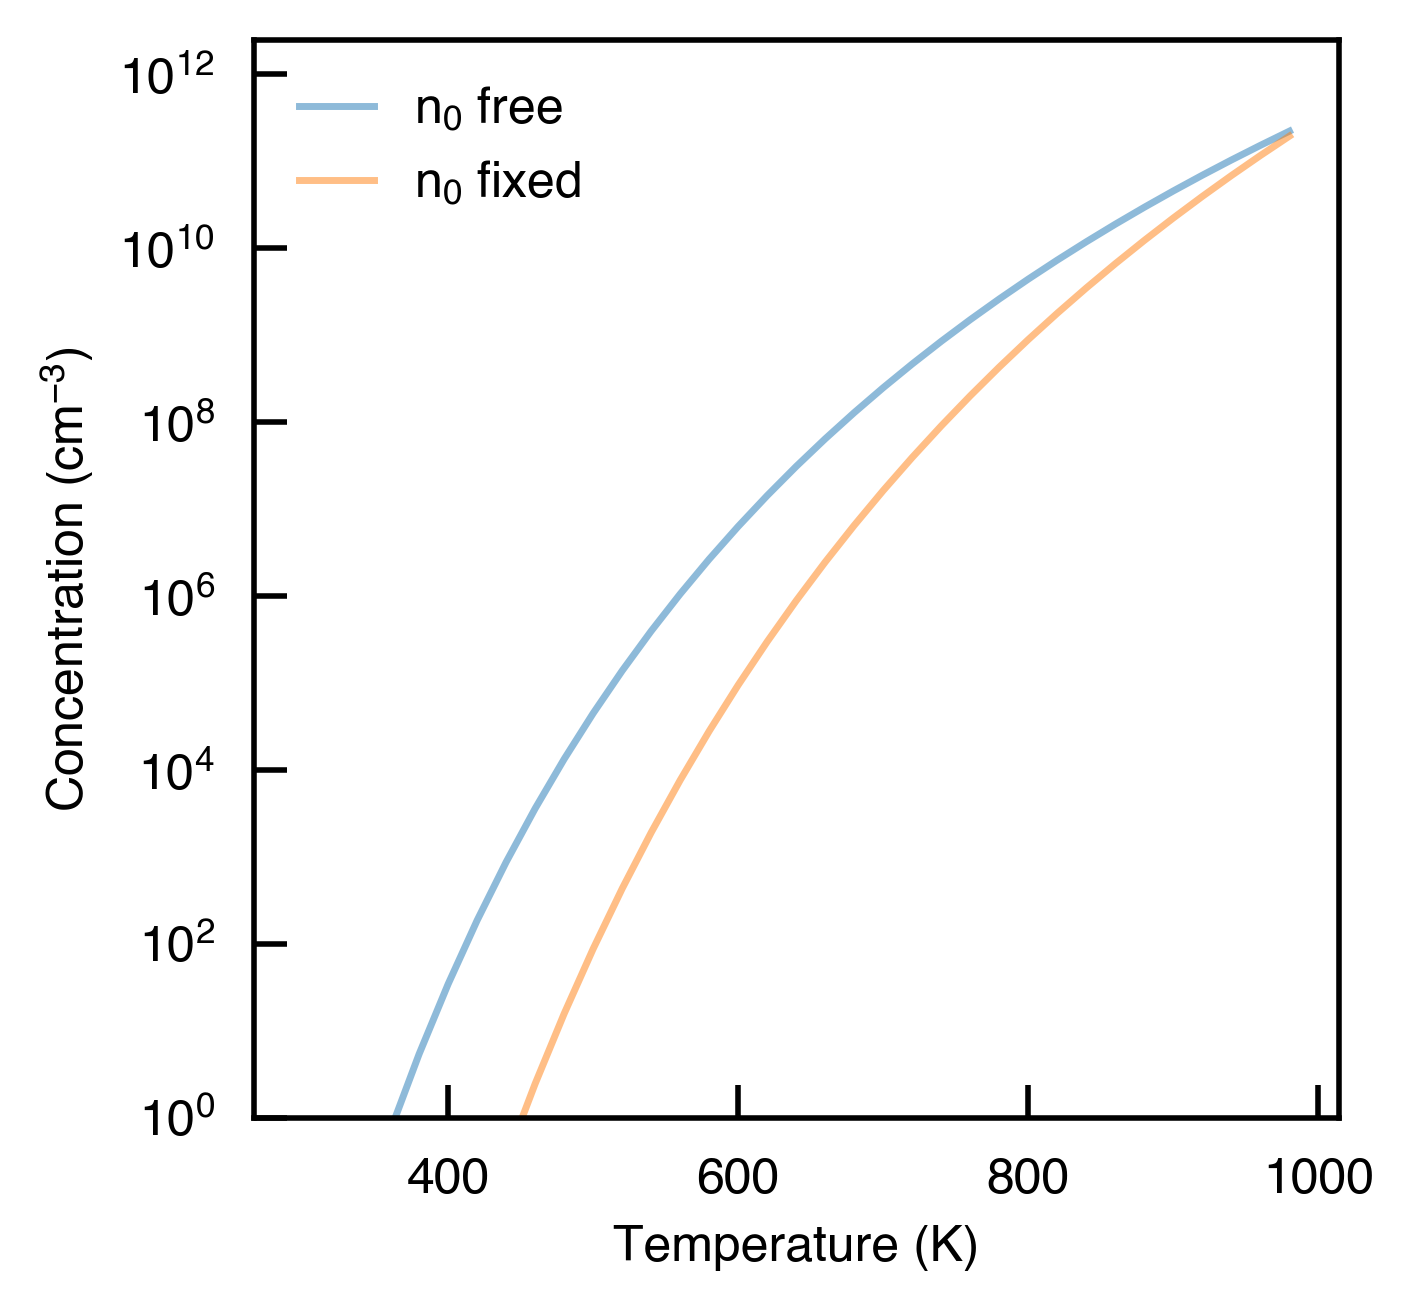

In [6]:

free = temperature_df[temperature_df['Defect'] == "n0"]
fixed = anneal_temperature_df[anneal_temperature_df['Defect'] == "n0"]

plt.plot(free['Temperature'], free['Concentration'], alpha= 0.5, label=r"$n_0$ free")
plt.plot(fixed['Temperature'], fixed['Concentration'], alpha= 0.5, label=r"$n_0$ fixed")

# Use a log scale on the y-axis due to the wide range of concentrations
plt.yscale('log')

# Add labels and title
plt.xlabel('Temperature (K)')
plt.ylabel('Concentration (cm$^{-3}$)')

# Add a legend to distinguish each defect type
plt.legend(frameon=False)
plt.ylim(1, None)

# Show the plot
plt.show()

In this next example, we'll scan over chemical potentials instead of temperature.

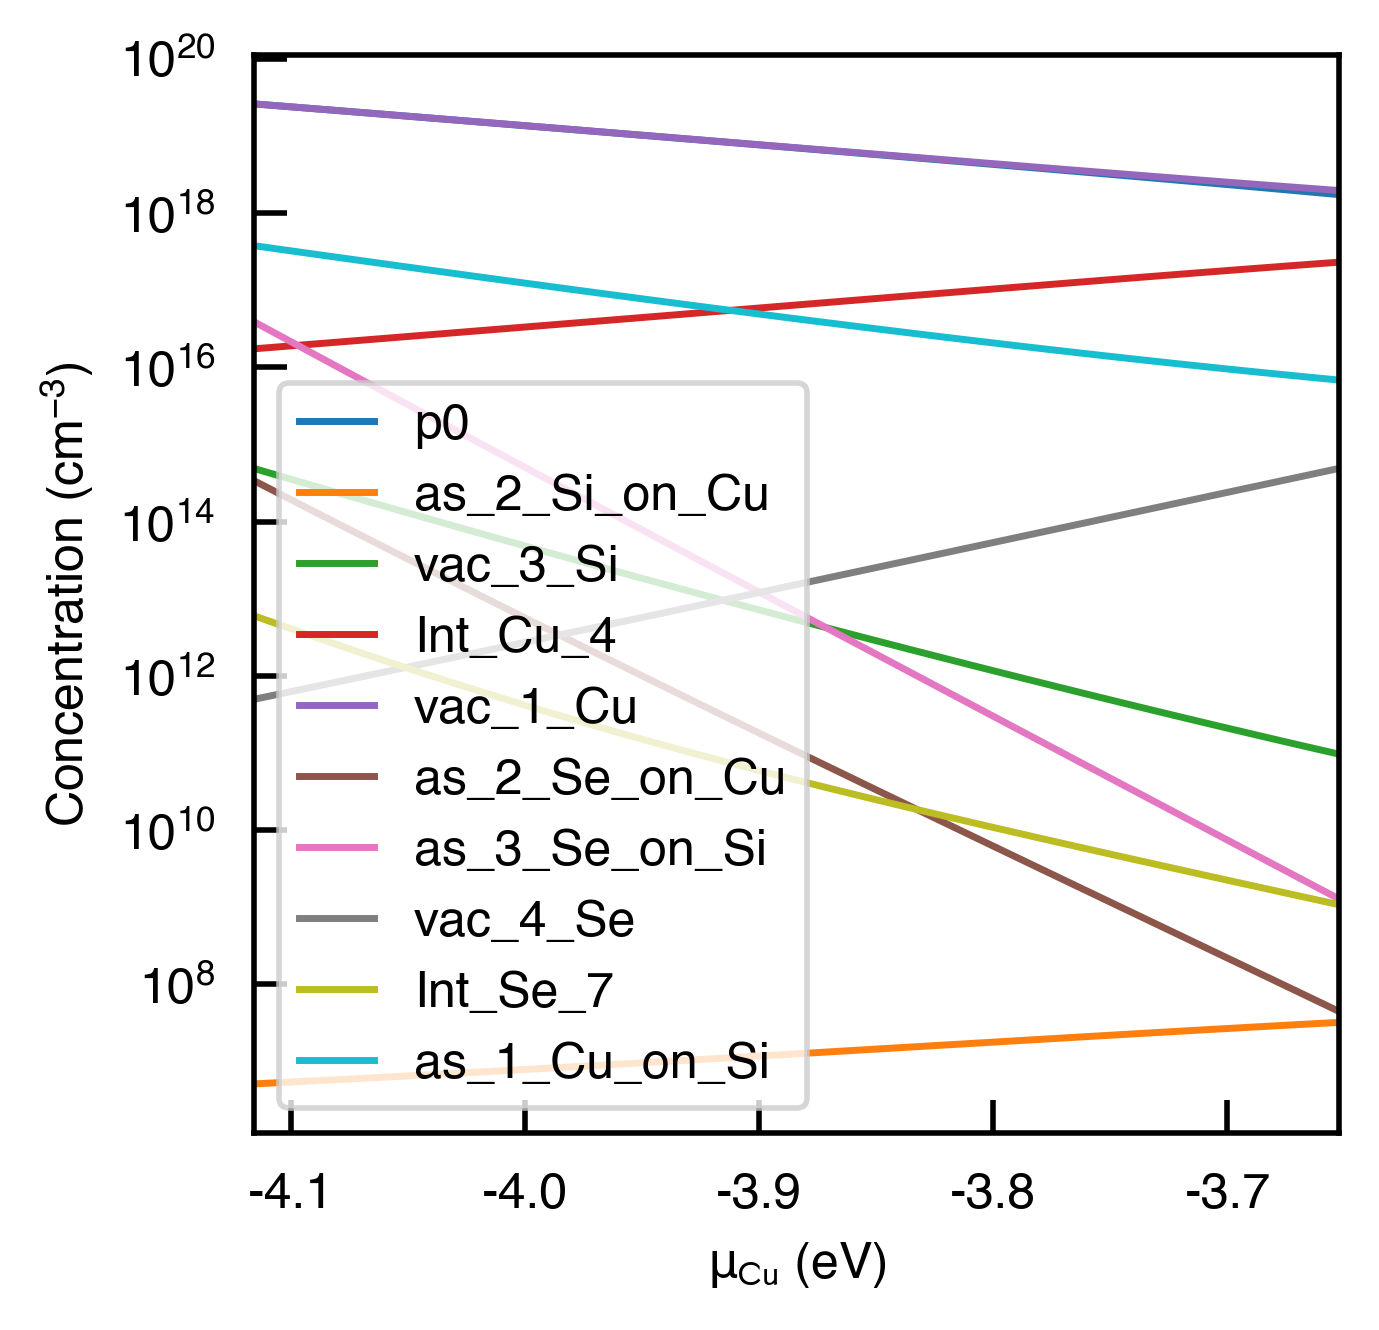

In [7]:
# define a range of chemical potentials to scan over
chem_pot_df = fs.interpolate_chemical_potentials_and_save(chem_pot_start=chemical_potentials["facets"]["Cu2SiSe3-Cu2Se-Cu"],
                                                chem_pot_end=chemical_potentials["facets"]["Cu2SiSe3-SiSe2-Se"],
                                                n_points=100, temp=300, anneal_temp=1000)

# Create a unique list of defects
unique_defects = chem_pot_df['Defect'].unique()

# Loop through each unique defect to plot it
for defect in unique_defects:
    subset = chem_pot_df[chem_pot_df['Defect'] == defect]
    if all(subset['Concentration'] > 1e6):
        plt.plot(subset['Cu'], subset['Concentration'], label=defect)

# Use a log scale on the y-axis due to the wide range of concentrations
plt.yscale('log')

# Add labels and title
plt.xlabel(r'$\mu_\mathrm{Cu}$ (eV)')
plt.ylabel('Concentration ($cm^{-3}$)')
plt.xlim(subset['Cu'].min(), subset['Cu'].max())

# Add a legend to distinguish each defect type
plt.legend()

# Show the plot
plt.show()

In [8]:
v = fs.chempot_grid(chemical_potentials, num_points=3, num_points_along_edge=3)

QhullError encountered. Trying to joggle the points.


In [9]:
concs = fs.grid_solve(v, temperature=300, anneal_temperature=1000)

0it [00:00, ?it/s]

1it [00:00,  1.95it/s]

3it [00:01,  2.94it/s]

4it [00:01,  2.55it/s]

6it [00:02,  2.27it/s]

7it [00:03,  2.18it/s]

9it [00:04,  1.77it/s]

10it [00:04,  1.83it/s]

12it [00:05,  1.96it/s]

14it [00:06,  2.48it/s]

16it [00:07,  1.92it/s]

17it [00:08,  1.95it/s]

18it [00:08,  1.97it/s]

19it [00:09,  1.62it/s]

21it [00:11,  1.56it/s]

22it [00:11,  1.67it/s]

23it [00:12,  1.76it/s]

24it [00:12,  1.82it/s]

25it [00:13,  1.87it/s]

26it [00:13,  1.55it/s]

29it [00:15,  1.81it/s]

30it [00:16,  1.56it/s]

32it [00:16,  2.05it/s]

34it [00:17,  2.44it/s]

37it [00:18,  3.47it/s]

38it [00:18,  3.00it/s]

39it [00:19,  2.68it/s]

40it [00:19,  2.47it/s]

42it [00:20,  2.83it/s]

43it [00:20,  2.58it/s]

44it [00:21,  2.40it/s]

45it [00:21,  2.28it/s]

46it [00:22,  2.18it/s]

47it [00:22,  2.09it/s]

48it [00:23,  2.03it/s]

49it [00:23,  1.99it/s]

50it [00:24,  1.97it/s]

51it [00:24,  1.96it/s]

52it [00:25,  1.92it/s]

53it [00:25,  1.93it/s]

54it [00:26,  1.95it/s]

55it [00:26,  1.95it/s]

56it [00:27,  1.95it/s]

57it [00:27,  1.94it/s]

58it [00:28,  1.95it/s]

59it [00:28,  1.94it/s]

61it [00:29,  2.45it/s]

62it [00:30,  2.29it/s]

65it [00:30,  3.50it/s]

66it [00:31,  2.31it/s]

67it [00:32,  2.27it/s]

69it [00:33,  1.82it/s]

70it [00:33,  1.84it/s]

71it [00:34,  1.52it/s]

72it [00:35,  1.36it/s]

74it [00:36,  1.64it/s]

75it [00:37,  1.72it/s]

76it [00:37,  1.79it/s]

77it [00:38,  1.82it/s]

79it [00:39,  1.92it/s]

80it [00:40,  1.57it/s]

81it [00:41,  1.39it/s]

83it [00:42,  1.43it/s]

85it [00:43,  1.68it/s]

86it [00:44,  1.44it/s]

87it [00:45,  1.32it/s]

89it [00:46,  1.40it/s]

91it [00:48,  1.44it/s]

92it [00:49,  1.32it/s]

94it [00:50,  1.40it/s]

95it [00:51,  1.30it/s]

96it [00:52,  1.23it/s]

99it [00:53,  1.61it/s]

100it [00:54,  1.69it/s]

103it [00:54,  2.90it/s]

104it [00:55,  2.60it/s]

107it [00:56,  1.88it/s]

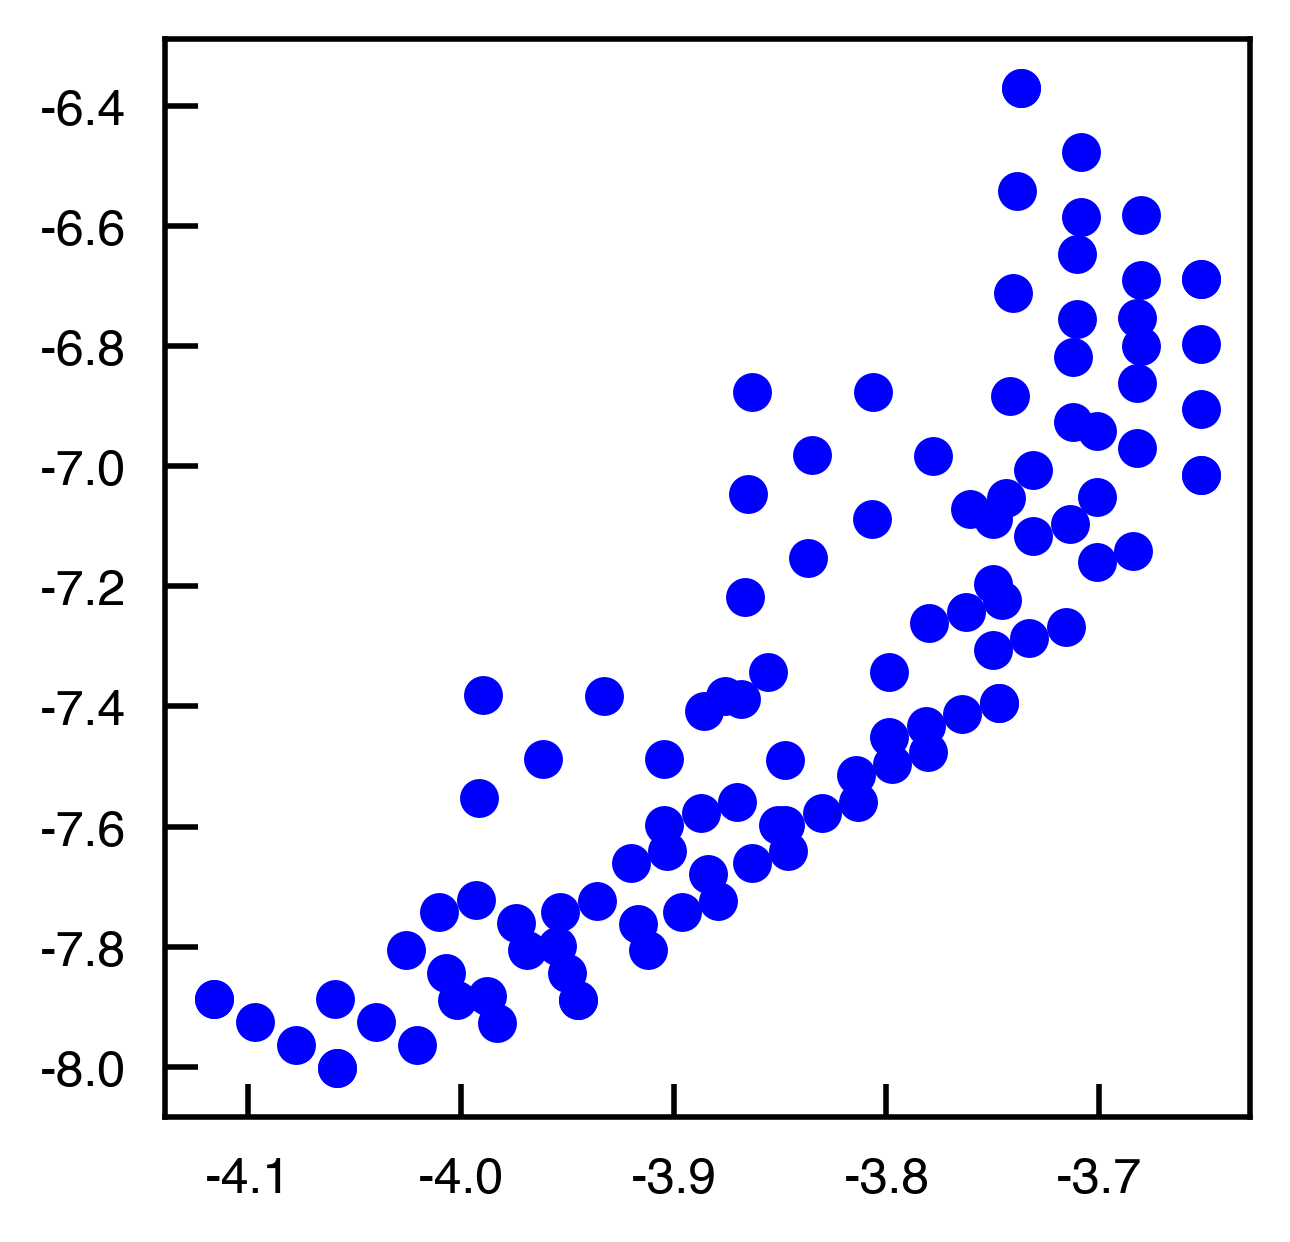

In [13]:
import matplotlib.pyplot as plt
import numpy as np



# Extract x, y, z coordinates
x = v["Cu"]
y = v["Si"]
z = v["Se"]

# Create the plot


# Plot the vertices


plt.scatter(x, y, c='b', marker='o')

# ax.view_init(elev=20, azim=30) 

# Show plot
plt.show()

In [14]:
print(concs)

             Defect  Concentration  Temperature        Cu        Si        Se  \
0                p0   4.221510e+18          300 -3.798695 -7.451372 -4.824277   
1                n0   1.460573e-10          300 -3.798695 -7.451372 -4.824277   
2     as_5_Si_on_Se   1.882246e+06          300 -3.798695 -7.451372 -4.824277   
3     as_2_Si_on_Cu   2.757923e+06          300 -3.798695 -7.451372 -4.824277   
4          vac_3_Si   7.393203e+12          300 -3.798695 -7.451372 -4.824277   
...             ...            ...          ...       ...       ...       ...   
1568  as_3_Se_on_Si   4.582985e+10          300 -3.836751 -7.152429 -4.898554   
1569       vac_4_Se   6.950988e+13          300 -3.836751 -7.152429 -4.898554   
1570      Int_Si_12   9.411671e+03          300 -3.836751 -7.152429 -4.898554   
1571       Int_Se_7   8.808033e+09          300 -3.836751 -7.152429 -4.898554   
1572  as_1_Cu_on_Si   2.494216e+15          300 -3.836751 -7.152429 -4.898554   

      Fermi Level  
0      

In [15]:
print(sliced_df)

NameError: name 'sliced_df' is not defined

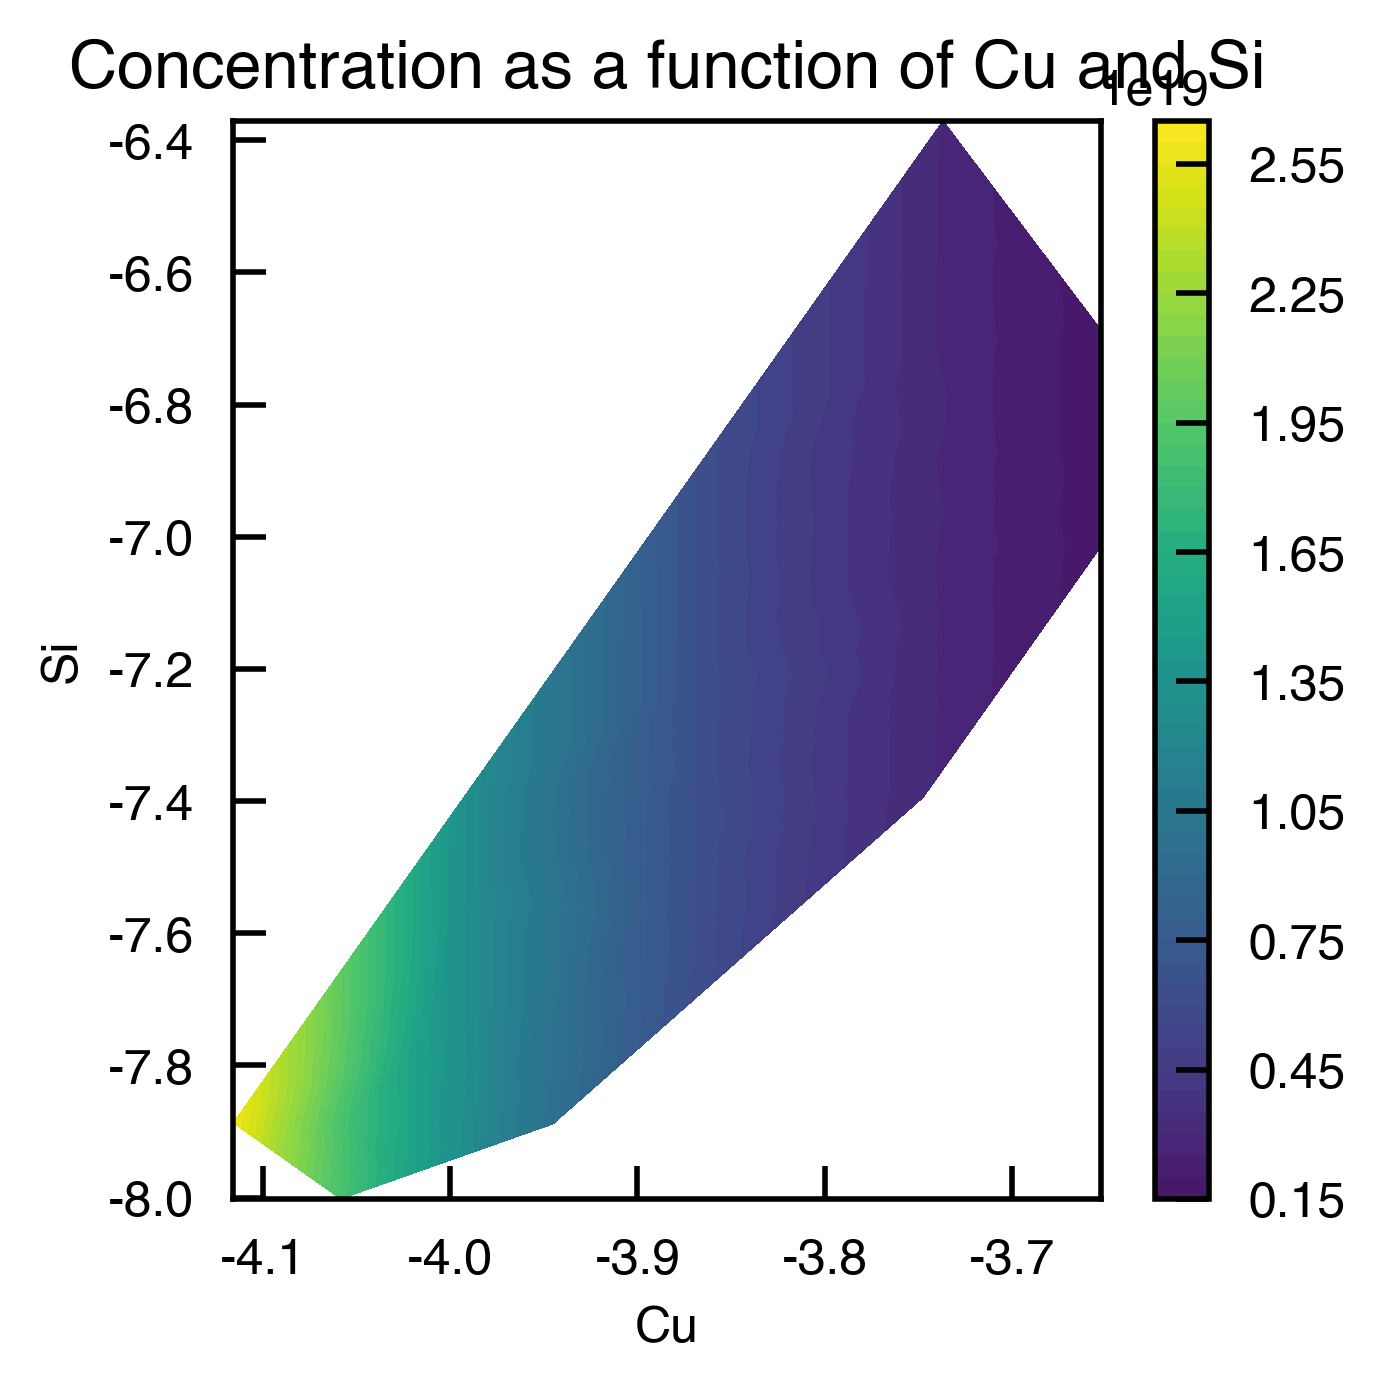

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume 'df' is your DataFrame
concs = concs[concs["Defect"] == "p0"]

# Create contour plot
plt.figure()


plt.tricontourf(concs["Cu"], concs["Si"], concs["Concentration"], levels=50, cmap='viridis', vmin = 1)

plt.colorbar()
plt.xlabel('Cu')
plt.ylabel('Si')
plt.title('Concentration as a function of Cu and Si')
plt.show()

,Defect,Concentration,Temperature,Cu,Si,Se,Fermi Level


,Cu,Si,Se


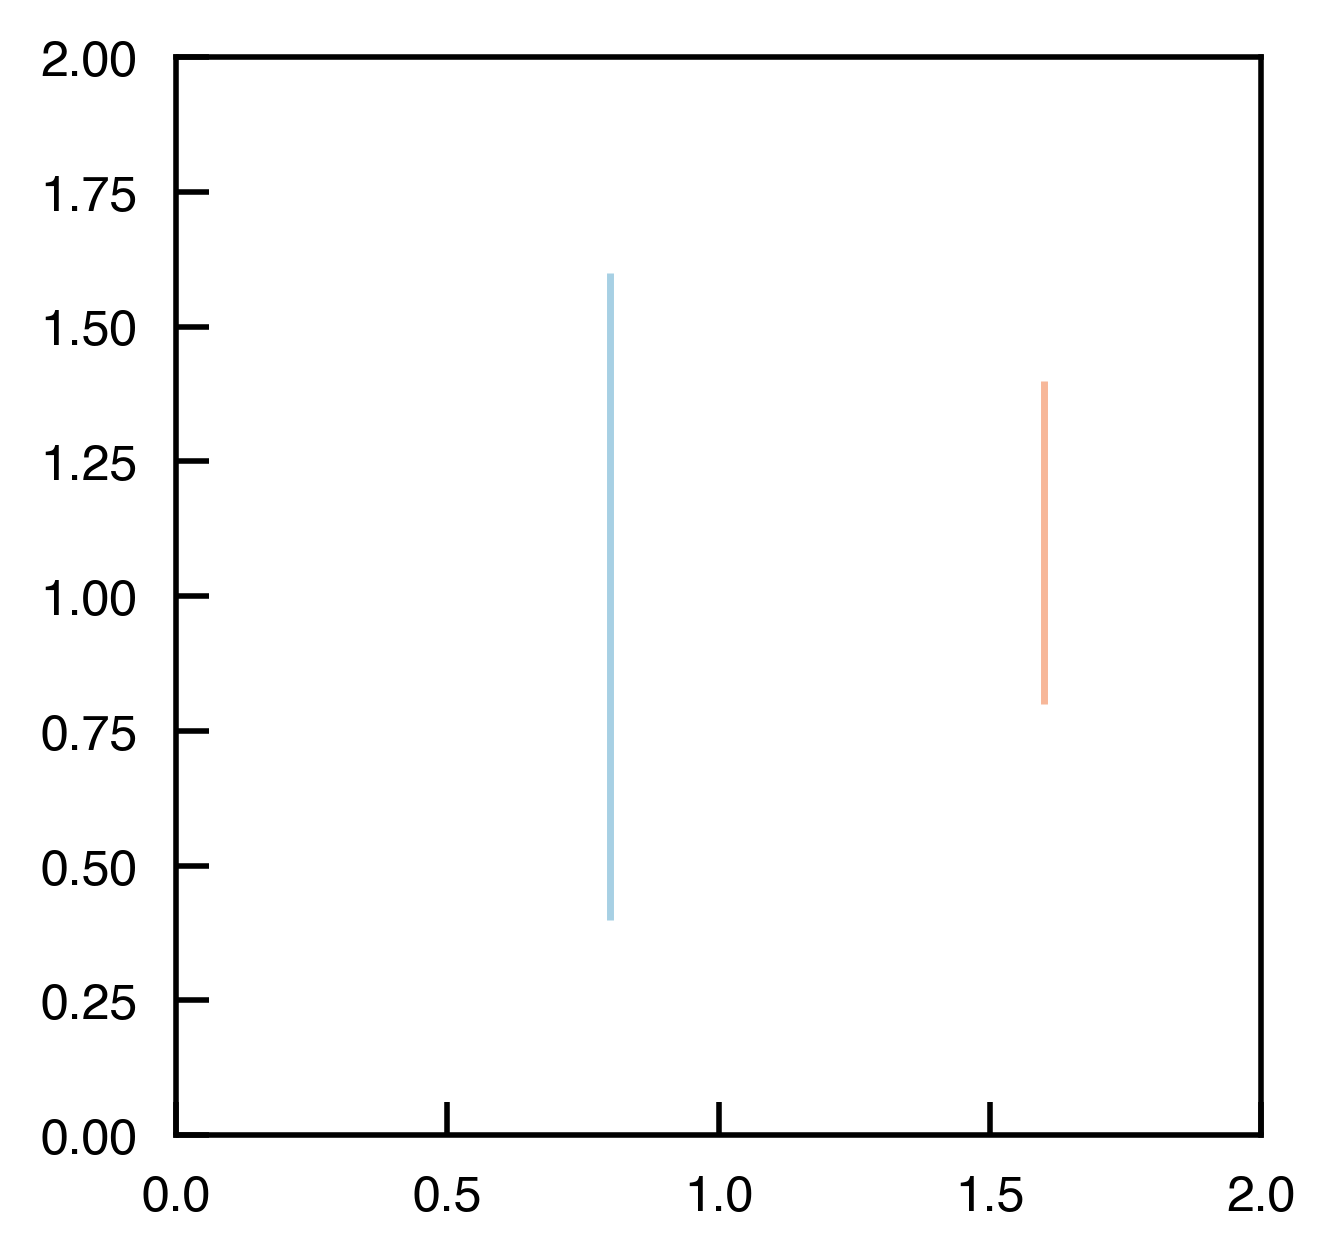

In [ ]:
plt.tricontour([0, 1, 2], [0, 2, 1], [0, 1, 2], levels=2, cmap="RdBu_r")

In [ ]:
concs

,Defect,Concentration,Temperature,Cu,Si,Se,Fermi Level
0,p0,4.221510e+18,300,-3.798695,-7.451372,-4.824277,-0.034125
1,p0,4.221510e+18,300,-3.798695,-7.451372,-4.824277,-0.034125
2,p0,4.221510e+18,300,-3.798695,-7.451372,-4.824277,-0.034125
3,p0,4.221510e+18,300,-3.798695,-7.451372,-4.824277,-0.034125
4,p0,4.221510e+18,300,-3.798695,-7.451372,-4.824277,-0.034125
...,...,...,...,...,...,...,...
11773,as_5_Si_on_Se,8.710380e+08,300,-3.796962,-7.055681,-4.957329,-0.033968
11774,vac_3_Si,7.574741e+10,300,-3.796962,-7.055681,-4.957329,-0.033968
11775,vac_3_Si,7.574741e+10,300,-3.796962,-7.055681,-4.957329,-0.033968
11776,as_3_Se_on_Si,7.495914e+09,300,-3.796962,-7.055681,-4.957329,-0.033968
